In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime
from datetime import datetime, timedelta

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes
from scipy.ndimage import map_coordinates

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import gaussian_vel_reconstruction, espra, calc_ow, normalize_matrix, smooth

def int_to_excel(n):
    # Convert 0-indexed integer n to an Excel-style column label in lowercase
    n += 1  # Convert to 1-indexed
    result = ""
    while n:
        n, remainder = divmod(n - 1, 26)
        result = chr(97 + remainder) + result  # 97 is ASCII for 'a'
    return result
    

In [2]:
sadcp_data = sio.loadmat('/srv/scratch/z5297792/IN2023/sadcp.mat', simplify_cells=True)

z_sadcp = sadcp_data['z_sadcp']
u_sadcp = pd.DataFrame(sadcp_data['u_sadcp'], index=[f'u{z}' for z in z_sadcp])
v_sadcp = pd.DataFrame(sadcp_data['v_sadcp'], index=[f'v{z}' for z in z_sadcp])
lat_sadcp = sadcp_data['lat_sadcp']
lon_sadcp = sadcp_data['lon_sadcp']
tim_sadcp = sadcp_data['tim_sadcp']
julian_dates = tim_sadcp
ref_date = datetime(2000, 1, 1, 12)  # Julian day 2451545.0
gregorian_dates = [ref_date + timedelta(days=jd - 2451545.0) for jd in julian_dates]
tim_sadcp = gregorian_dates

df_sadcp = pd.DataFrame({'Lon': lon_sadcp, 'Lat': lat_sadcp, 'Time': tim_sadcp})
df_sadcp = pd.concat([df_sadcp, u_sadcp.T, v_sadcp.T], axis=1)

# pd.Timestamp('2023-10-18 20:00:00')


In [3]:
# df_espra = pd.DataFrame(columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'z', 'Time']) 
# for time in pd.date_range(start='2023-10-17 18:00:00', end='2023-10-22 11:00:00', freq='6h'):
#     t0 = time - pd.Timedelta(days=1)
#     t1 = time + pd.Timedelta(days=1)
    
#     df_data = df_sadcp[(df_sadcp['Time'] >= t0) & (df_sadcp['Time'] <= t1)]

#     for z in z_sadcp:
#         ui = df_data[f'u{z}']
#         mask = ~np.isnan(ui)
#         if np.any(mask):
#             ui = ui[mask]
#             vi = df_data[f'v{z}'][mask]
#             xi = df_data['Lon'][mask]
#             yi = df_data['Lat'][mask]
#             xc, yc, w, Q, Rc, psi0 = espra(xi, yi, ui, vi) 
#             df_espra.loc[len(df_espra)] = {'xc': xc, 'yc': yc, 'w': w, 'Q': Q, 'Rc': Rc, 'psi0': psi0, 'z': z, 'Time': time}
# df_espra.to_pickle("/srv/scratch/z5297792/IN2023/df_IN23_ESPRA.pkl")
df_espra = pd.read_pickle("/srv/scratch/z5297792/IN2023/df_IN23_ESPRA.pkl")
df_espra


,xc,yc,w,Q,Rc,psi0,z,Time
0,154.378042,-37.279913,-2.282348,"[[-1.0583306256763825, 0.01228981955758548], [...",0.522307,0.361272,37,2023-10-17 18:00:00
1,154.379052,-37.303245,-2.248442,"[[-1.0404477170443764, 0.01345508961553748], [...",0.497675,0.337544,47,2023-10-17 18:00:00
2,154.380111,-37.319471,-2.261453,"[[-1.0423449996812832, 0.010347737669124446], ...",0.485998,0.331441,57,2023-10-17 18:00:00
3,154.380603,-37.322626,-2.263124,"[[-1.0361406132180457, 0.003424295612869868], ...",0.520164,0.367942,67,2023-10-17 18:00:00
4,154.382516,-37.297720,-2.143972,"[[-0.9759436918348886, 0.002118811241047446], ...",0.657435,0.519045,77,2023-10-17 18:00:00
...,...,...,...,...,...,...,...,...
1416,154.094426,-39.619000,-0.808313,"[[-0.3732135450095974, 0.024579698120135343], ...",2.040032,4.410143,717,2023-10-22 06:00:00
1417,154.034549,-40.781782,-0.800062,"[[-0.3768180395526645, 0.024185871391132527], ...",2.013391,4.332415,727,2023-10-22 06:00:00
1418,151.875223,-77.033125,-0.688774,"[[-0.340546887246756, 0.02050067395838607], [0...",3.698213,16.585678,737,2023-10-22 06:00:00
1419,152.478615,-55.638295,1.788809,"[[0.8922720944756181, -0.08011115144657821], [...",3.879717,-14.125338,747,2023-10-22 06:00:00


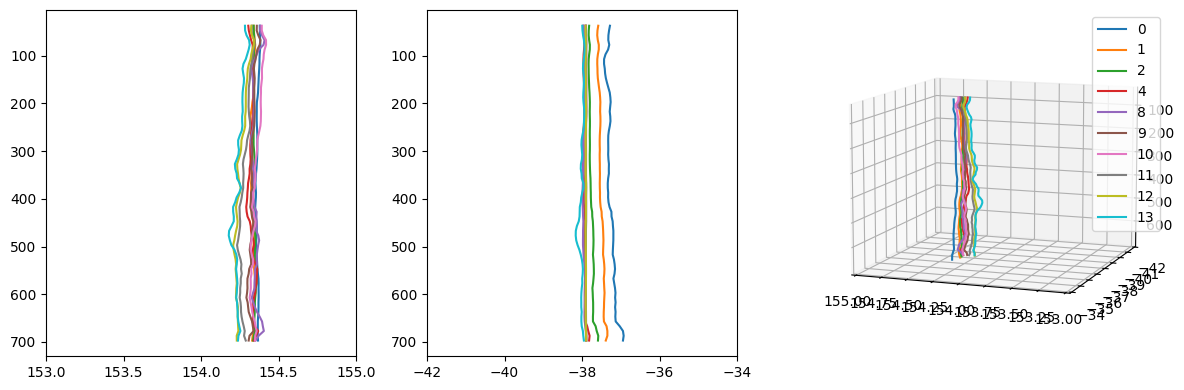

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1.2])

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2], projection='3d')  # 3D plot

duds = [3, 5, 6, 7, 14, 15, 16, 17, 18]

for t, time in enumerate(df_espra['Time'].unique()):
    if t not in duds:
        df = df_espra[df_espra['Time'] == time]
        mask = df['z'] <= 700
        ax0.plot(df.loc[mask]['xc'], df.loc[mask]['z'])
        ax1.plot(df.loc[mask]['yc'], df.loc[mask]['z'])
        ax2.plot(df.loc[mask]['xc'], df.loc[mask]['yc'], df.loc[mask]['z'], label=t)
ax2.legend()
ax0.invert_yaxis(); ax1.invert_yaxis(); ax2.invert_zaxis()

ax0.set_xlim(153, 155)
ax1.set_xlim(-42, -34)
ax2.set_xlim(153, 155)
ax2.set_ylim(-42, -34)

ax2.view_init(elev=10, azim=110)

plt.tight_layout()
plt.show()


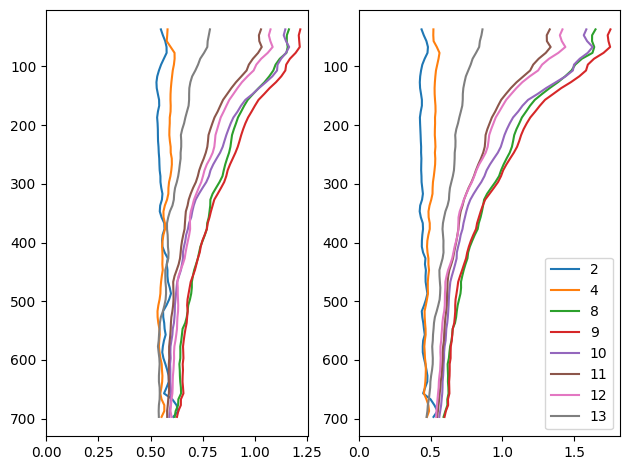

In [5]:
fig, axs = plt.subplots(1, 2)
for t, time in enumerate(df_espra['Time'].unique()):
    if t not in duds + [0, 1]:
        df = df_espra[df_espra['Time']==time]
        df = df[df['z'] <= 700]
        axs[0].plot(df['Rc'], df['z'], label=t)
        axs[1].plot(df['psi0'], df['z'], label=t)
plt.legend()
axs[0].invert_yaxis(); axs[1].invert_yaxis()
axs[0].set_xlim(0, None); axs[1].set_xlim(0, None); 
plt.tight_layout()


### Cherry Pick

In [6]:
all_times = np.arange(df_espra['Time'].nunique())
exclude = [0, 1, 3, 5, 6, 7, 14, 15, 16, 17, 18]
valid_times = df_espra['Time'].unique()[np.setdiff1d(all_times, exclude)]
valid_times

<DatetimeArray>
['2023-10-18 06:00:00', '2023-10-18 18:00:00', '2023-10-19 18:00:00',
 '2023-10-20 00:00:00', '2023-10-20 06:00:00', '2023-10-20 12:00:00',
 '2023-10-20 18:00:00', '2023-10-21 00:00:00']
Length: 8, dtype: datetime64[ns]

In [7]:
df_data = df_espra[df_espra['Time'].isin(valid_times)]
df_data = df_data[df_data['z'] <= 700]
df_data


,xc,yc,w,Q,Rc,psi0,z,Time
150,154.338385,-37.816724,-2.379379,"[[-0.9188018060979587, -0.048742283575588866],...",0.549522,0.437802,37,2023-10-18 06:00:00
151,154.339112,-37.827637,-2.349484,"[[-0.8966834395162571, -0.045057322650234835],...",0.559087,0.453236,47,2023-10-18 06:00:00
152,154.341440,-37.829541,-2.318569,"[[-0.8742703823690235, -0.03963771263875762], ...",0.570310,0.471699,57,2023-10-18 06:00:00
153,154.343056,-37.817158,-2.224875,"[[-0.8274308029698325, -0.03504276334502341], ...",0.576630,0.482144,67,2023-10-18 06:00:00
154,154.343757,-37.798256,-2.084002,"[[-0.7665911232007778, -0.034087080099357944],...",0.577041,0.479080,77,2023-10-18 06:00:00
...,...,...,...,...,...,...,...,...
1037,154.239740,-38.016965,-0.730182,"[[-0.22365253674492674, 0.042226490124336456],...",0.544118,0.493055,657,2023-10-21 00:00:00
1038,154.246008,-38.008190,-0.725066,"[[-0.2210145344566451, 0.044191053921878415], ...",0.543414,0.488575,667,2023-10-21 00:00:00
1039,154.253352,-37.978422,-0.722491,"[[-0.21833633531051613, 0.04314715939348095], ...",0.540049,0.481406,677,2023-10-21 00:00:00
1040,154.240715,-37.967875,-0.718264,"[[-0.21353098992772301, 0.04203236301581096], ...",0.538952,0.478445,687,2023-10-21 00:00:00


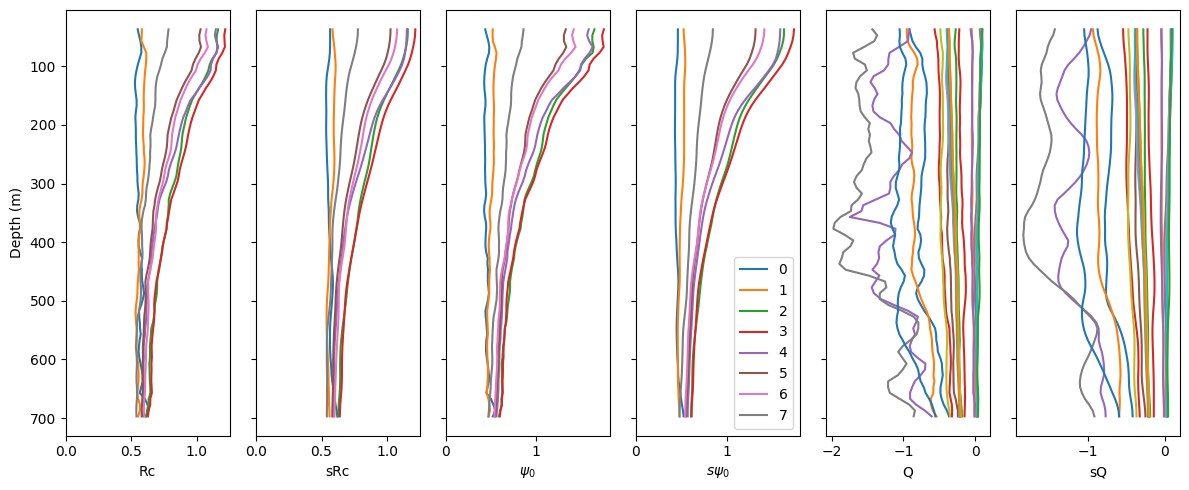

In [8]:
fig, axs = plt.subplots(1, 6, figsize=(12,5), sharey=True)
sRcs, spsi0s = [], []
sQ11s, sQ12s, sQ22s = [], [], []
for t, time in enumerate(df_data['Time'].unique()):
    df = df_data[df_data['Time']==time]
    axs[0].plot(df['Rc'], df['z'])
    sRc = smooth(df['Rc'], df['z'])
    sRcs.extend(sRc)
    axs[1].plot(sRc, df['z'])
    axs[2].plot(df['psi0'], df['z'])
    spsi0 = smooth(df['psi0'], df['z'])
    spsi0s.extend(spsi0)
    axs[3].plot(spsi0, df['z'], label=t)
    axs[3].legend()

    Q11 = df['Q'].apply(lambda Q: Q[0, 0])
    axs[4].plot(Q11, df['z'])
    sQ11 = smooth(Q11, df['z'])
    sQ11s.extend(sQ11)
    axs[5].plot(sQ11, df['z'])

    Q12 = df['Q'].apply(lambda Q: Q[0, 1])
    axs[4].plot(Q12, df['z'])
    sQ12 = smooth(Q12, df['z'])
    sQ12s.extend(sQ12)
    axs[5].plot(sQ12, df['z'])

    Q22 = df['Q'].apply(lambda Q: Q[1, 1])
    axs[4].plot(Q22, df['z'])
    sQ22 = smooth(Q22, df['z'])
    sQ22s.extend(sQ22)
    axs[5].plot(sQ22, df['z'])
    
df_data['sRc'] = sRcs
df_data['spsi0'] = spsi0s
df_data['sQ11'] = sQ11s
df_data['sQ12'] = sQ12s
df_data['sQ22'] = sQ22s

axs[0].invert_yaxis()
axs[0].set_xlabel('Rc')
axs[0].set_ylabel('Depth (m)')
axs[1].set_xlabel('sRc')
axs[2].set_xlabel(r'$\psi_0$')
axs[3].set_xlabel(r'$s\psi_0$')
axs[4].set_xlabel('Q')
axs[5].set_xlabel('sQ')
for a, ax in enumerate(axs):
    if a <= 3:
        ax.set_xlim(0, None)
plt.tight_layout()


### Pick 1

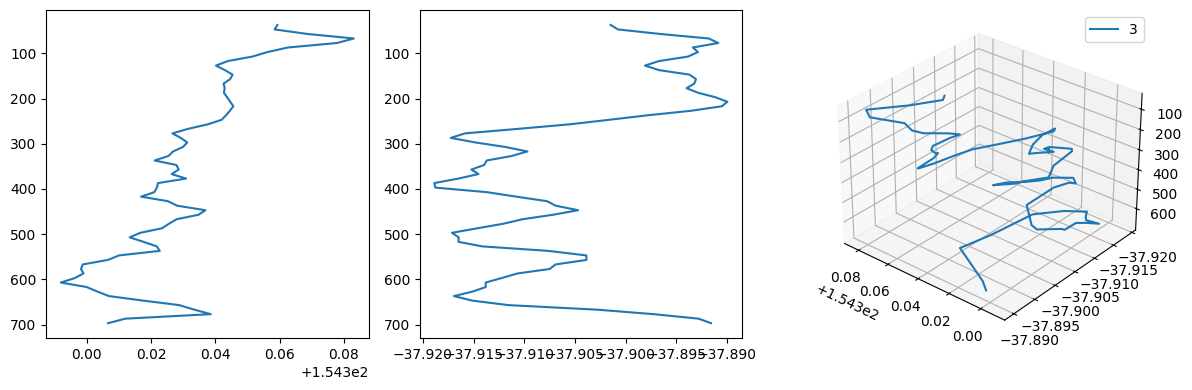

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1.2])

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2], projection='3d')  # 3D plot

t = 3
df = df_data[df_data['Time'] == df_data['Time'].unique()[t]]
ax0.plot(df['xc'], df['z'])
ax1.plot(df['yc'], df['z'])
ax2.plot(df['xc'], df['yc'], df['z'], label=t)
ax2.legend()
ax0.invert_yaxis(); ax1.invert_yaxis(); ax2.invert_zaxis()

ax2.view_init(elev=30, azim=130)

plt.tight_layout()
plt.show()


In [10]:
lon = np.arange(153, 156, .1)
lat = np.arange(-39, -36.5, .1)
Lon, Lat = np.meshgrid(lon, lat)

df = df_data[df_data['Time'] == df_data['Time'].unique()[t]]
U = np.zeros((Lon.shape[0], Lon.shape[1], len(df)))
V = np.zeros_like(U)

for i, (_, row) in enumerate(df.iterrows()):
    u, v, _, _ = gaussian_vel_reconstruction(
        row.xc, row.yc,
        row.sQ11, row.sQ12, row.sQ22,
        row.sRc, row.spsi0,
        X=Lon, Y=Lat
    )
    U[:, :, i], V[:, :, i] = u, v
    

(np.float64(152.85500000000002),
 np.float64(156.04499999999982),
 np.float64(-39.120000000000005),
 np.float64(-36.47999999999996))

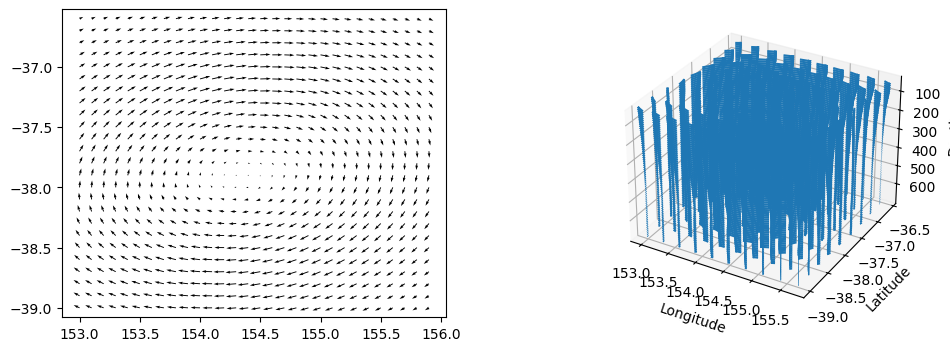

In [11]:
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(figsize=(12, 4))
# ax = fig.add_subplot(111, projection='3d')
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.2])

ax1 = fig.add_subplot(gs[0])
ax = fig.add_subplot(gs[1], projection='3d')  # 3D plot
spacing = 3
for i, (_, row) in enumerate(df.iterrows()):
    z_plane = row['z'] * np.ones_like(Lon)
    ax.quiver(Lon[::spacing, ::spacing], Lat[::spacing, ::spacing], z_plane[::spacing, ::spacing],
              U[::spacing, ::spacing, i], V[::spacing, ::spacing, i], np.zeros_like(U[::spacing, ::spacing, i]), length=.2)
ax.invert_zaxis()
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth')

ax1.quiver(Lon, Lat, U[:,:,0], V[:,:,0])
ax1.axis('equal')



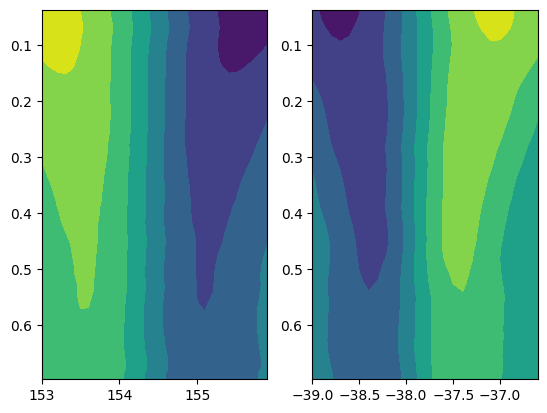

In [12]:
fig, axs = plt.subplots(1, 2)

axs[0].contourf(lon, df['z']/1000, V[V.shape[0]//2, :, :].T)
axs[0].invert_yaxis()
axs[1].contourf(lat, df['z']/1000, U[:,U.shape[1]//2, :].T)
axs[1].invert_yaxis()


In [13]:
lon0 = np.mean(Lon)
lat0 = np.mean(Lat)

X = (Lon - lon0) * 111 * np.cos(np.deg2rad(lat0))  # in km
Y = (Lat - lat0) * 111 


(np.float64(-139.8929941660474),
 np.float64(139.89299416604493),
 np.float64(-146.52000000000209),
 np.float64(146.52000000000209))

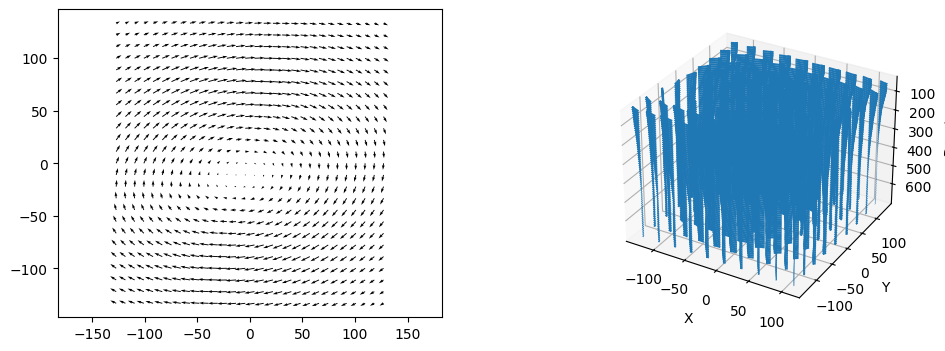

In [14]:
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.2])

ax1 = fig.add_subplot(gs[0])
ax = fig.add_subplot(gs[1], projection='3d')  # 3D plot

spacing = 3
for i, (_, row) in enumerate(df.iterrows()):
    z_plane = row['z'] * np.ones_like(X)
    ax.quiver(X[::spacing, ::spacing], Y[::spacing, ::spacing], z_plane[::spacing, ::spacing],
              U[::spacing, ::spacing, i], V[::spacing, ::spacing, i], np.zeros_like(U[::spacing, ::spacing, i]), length=20)
ax.invert_zaxis()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Depth')

ax1.quiver(X, Y, U[:,:,0], V[:,:,0])
ax1.axis('equal')


In [15]:
dx, dy = np.diff(X[0,:])[0], np.diff(Y[:,0])[0]
ow = calc_ow(U, V, dx, dy, transpose=True)
sigma_ow = normalize_matrix(ow)


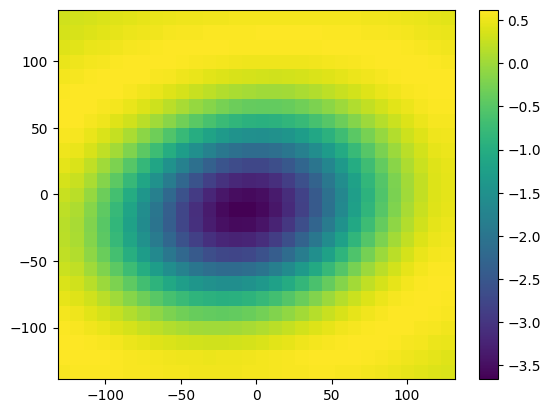

In [16]:
plt.pcolor(X, Y, sigma_ow[:,:,0])
plt.colorbar()


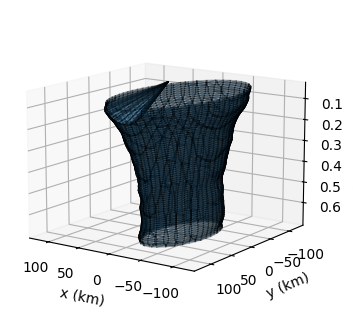

In [17]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111, projection='3d')

Xg, Yg, Zg = np.meshgrid(X[0,:], Y[:,0], df['z']/1000, indexing='ij')
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes
from scipy.ndimage import map_coordinates
verts, faces, normals, values = marching_cubes(sigma_ow, level=-.2)
pts = verts.T
real_x = map_coordinates(Xg, pts, order=1)
real_y = map_coordinates(Yg, pts, order=1)
real_z = map_coordinates(Zg, pts, order=1)
real_verts = np.vstack((real_x, real_y, real_z)).T

mesh = Poly3DCollection(real_verts[faces], alpha=0.3)
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)
ax.set_xlim(Xg.min(), Xg.max())
ax.set_ylim(Yg.min(), Yg.max())
ax.set_zlim(Zg.min(), Zg.max())
ax.invert_zaxis()
ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
ax.set_zlabel('Depth (km)')
ax.view_init(elev=13, azim=125)





#### Generalise

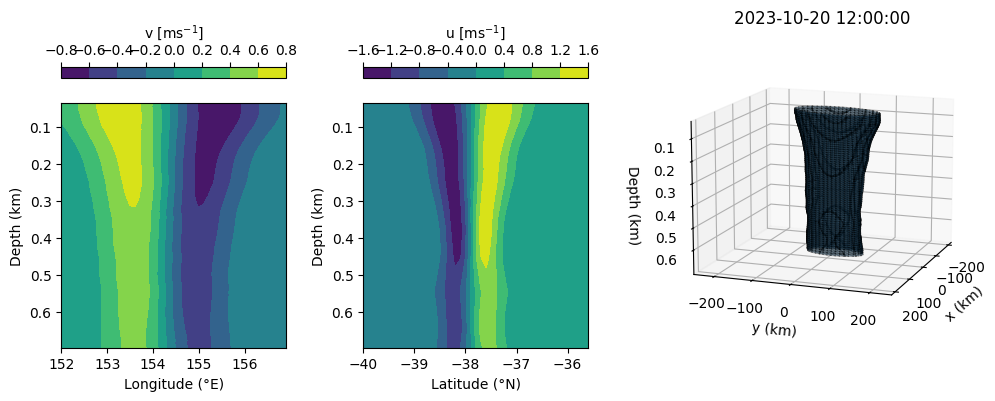

In [18]:
t = 5
lon = np.arange(152, 157, .1)
lat = np.arange(-40, -35.5, .1)
Lon, Lat = np.meshgrid(lon, lat)

df = df_data[df_data['Time'] == df_data['Time'].unique()[t]]
U = np.zeros((Lon.shape[0], Lon.shape[1], len(df)))
V = np.zeros_like(U)
for i, (_, row) in enumerate(df.iterrows()):
    u, v, _, _ = gaussian_vel_reconstruction(
        row.xc, row.yc,
        row.sQ11, row.sQ12, row.sQ22,
        row.sRc, row.spsi0,
        X=Lon, Y=Lat
    )
    U[:, :, i], V[:, :, i] = u, v

lon0 = np.mean(Lon)
lat0 = np.mean(Lat)
X = (Lon - lon0) * 111 * np.cos(np.deg2rad(lat0))  # in km
Y = (Lat - lat0) * 111 
dx, dy = np.diff(X[0,:])[0], np.diff(Y[:,0])[0]
ow = calc_ow(U, V, dx, dy, transpose=True)
sigma_ow = normalize_matrix(ow)
Xg, Yg, Zg = np.meshgrid(X[0,:], Y[:,0], df['z']/1000, indexing='ij')

# PLOT
fig = plt.figure(figsize=(10, 4))
gs  = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1.4], figure=fig)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax  = fig.add_subplot(gs[2], projection='3d')

cf0 = ax0.contourf(lon, df['z']/1000, V[V.shape[0]//2, :, :].T)
ax0.invert_yaxis()
ax0.set_xlabel('Longitude (°E)')
ax0.set_ylabel('Depth (km)')

cf1 = ax1.contourf(lat, df['z']/1000, U[:,U.shape[1]//2, :].T)
ax1.invert_yaxis()
ax1.set_xlabel('Latitude (°N)')
ax1.set_ylabel('Depth (km)')

fig.colorbar(cf0, ax=ax0, orientation='horizontal', pad=0.08, location='top', label=r'v [ms$^{-1}$]')
fig.colorbar(cf1, ax=ax1, orientation='horizontal', pad=0.08, location='top', label=r'u [ms$^{-1}$]')

verts, faces, normals, values = marching_cubes(sigma_ow, level=-.2)
pts        = verts.T
real_x     = map_coordinates(Xg, pts, order=1)
real_y     = map_coordinates(Yg, pts, order=1)
real_z     = map_coordinates(Zg, pts, order=1)
real_verts = np.vstack((real_x, real_y, real_z)).T

mesh = Poly3DCollection(real_verts[faces], alpha=0.3)
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)
ax.set_xlim(Xg.min(), Xg.max())
ax.set_ylim(Yg.min(), Yg.max())
ax.set_zlim(Zg.min(), Zg.max())
ax.invert_zaxis()
ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
ax.set_zlabel('Depth (km)')
ax.view_init(elev=13, azim=20)
ax.set_title(df_data['Time'].unique()[t])

plt.tight_layout()
plt.show()


/scratch/pbs.6588926.kman.restech.unsw.edu.au/ipykernel_1379371/324632850.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


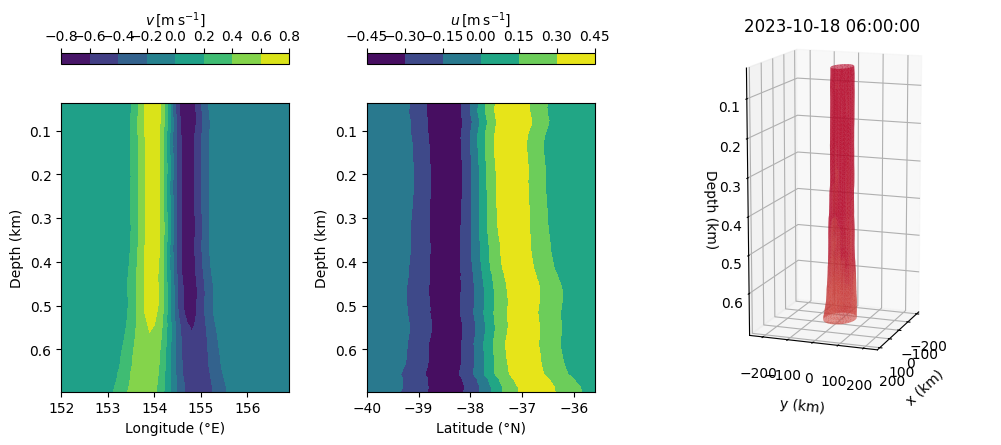

In [19]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes
from scipy.ndimage import map_coordinates
from matplotlib import cm

t = 0
lon = np.arange(152, 157, .1)
lat = np.arange(-40, -35.5, .1)
Lon, Lat = np.meshgrid(lon, lat)

df = df_data[df_data['Time'] == df_data['Time'].unique()[t]]
U = np.zeros((Lon.shape[0], Lon.shape[1], len(df)))
V = np.zeros_like(U)
for i, (_, row) in enumerate(df.iterrows()):
    u, v, _, _ = gaussian_vel_reconstruction(
        row.xc, row.yc,
        row.sQ11, row.sQ12, row.sQ22,
        row.sRc, row.spsi0,
        X=Lon, Y=Lat
    )
    U[:, :, i], V[:, :, i] = u, v

lon0 = Lon.mean()
lat0 = Lat.mean()
X = (Lon - lon0) * 111 * np.cos(np.deg2rad(lat0))
Y = (Lat - lat0) * 111
dx, dy = np.diff(X[0, :])[0], np.diff(Y[:, 0])[0]

ow = calc_ow(U, V, dx, dy, transpose=True)
sigma_ow = normalize_matrix(ow)
Xg, Yg, Zg = np.meshgrid(X[0, :], Y[:, 0], df['z']/1000, indexing='ij')

v_slice = V[V.shape[0]//2, :, :].T
u_slice = U[:, U.shape[1]//2, :].T

fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1.4], wspace=0.3, figure=fig)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2], projection='3d')

cf0 = ax0.contourf(lon, df['z']/1000, v_slice, cmap='viridis',
                   vmin=v_slice.min(), vmax=v_slice.max())
cf1 = ax1.contourf(lat, df['z']/1000, u_slice, cmap='viridis',
                   vmin=u_slice.min(), vmax=u_slice.max())
ax0.invert_yaxis(); ax1.invert_yaxis()
ax0.set(xlabel='Longitude (°E)', ylabel='Depth (km)')
ax1.set(xlabel='Latitude (°N)',  ylabel='Depth (km)')
fig.colorbar(cf0, ax=ax0, orientation='horizontal', pad=0.1,
             location='top', label=r'$v\,$[m s$^{-1}$]')
fig.colorbar(cf1, ax=ax1, orientation='horizontal', pad=0.1,
             location='top', label=r'$u\,$[m s$^{-1}$]')

verts, faces, normals, values = marching_cubes(sigma_ow, level=-.2)
pts = verts.T
real_x = map_coordinates(Xg, pts, order=1)
real_y = map_coordinates(Yg, pts, order=1)
real_z = map_coordinates(Zg, pts, order=1)
real_verts = np.vstack((real_x, real_y, real_z)).T

norm3 = plt.Normalize(sigma_ow.min(), sigma_ow.max())
face_vals = values[faces].mean(axis=1)
colors = cm.coolwarm(norm3(face_vals))
mesh = Poly3DCollection(real_verts[faces], facecolors=colors,
                        edgecolor='none', alpha=0.7)
ax2.add_collection3d(mesh)
ax2.set(xlim=(Xg.min(), Xg.max()),
         ylim=(Yg.min(), Yg.max()),
         zlim=(Zg.min(), Zg.max()),
         xlabel='x (km)', ylabel='y (km)', zlabel='Depth (km)')
ax2.invert_zaxis()
ax2.view_init(elev=13, azim=20)
ax2.set_box_aspect((1, 1, 2))
ax2.set_title(str(df_data['Time'].unique()[t]))

plt.tight_layout()
plt.show()


/scratch/pbs.6588926.kman.restech.unsw.edu.au/ipykernel_1379371/2306695083.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


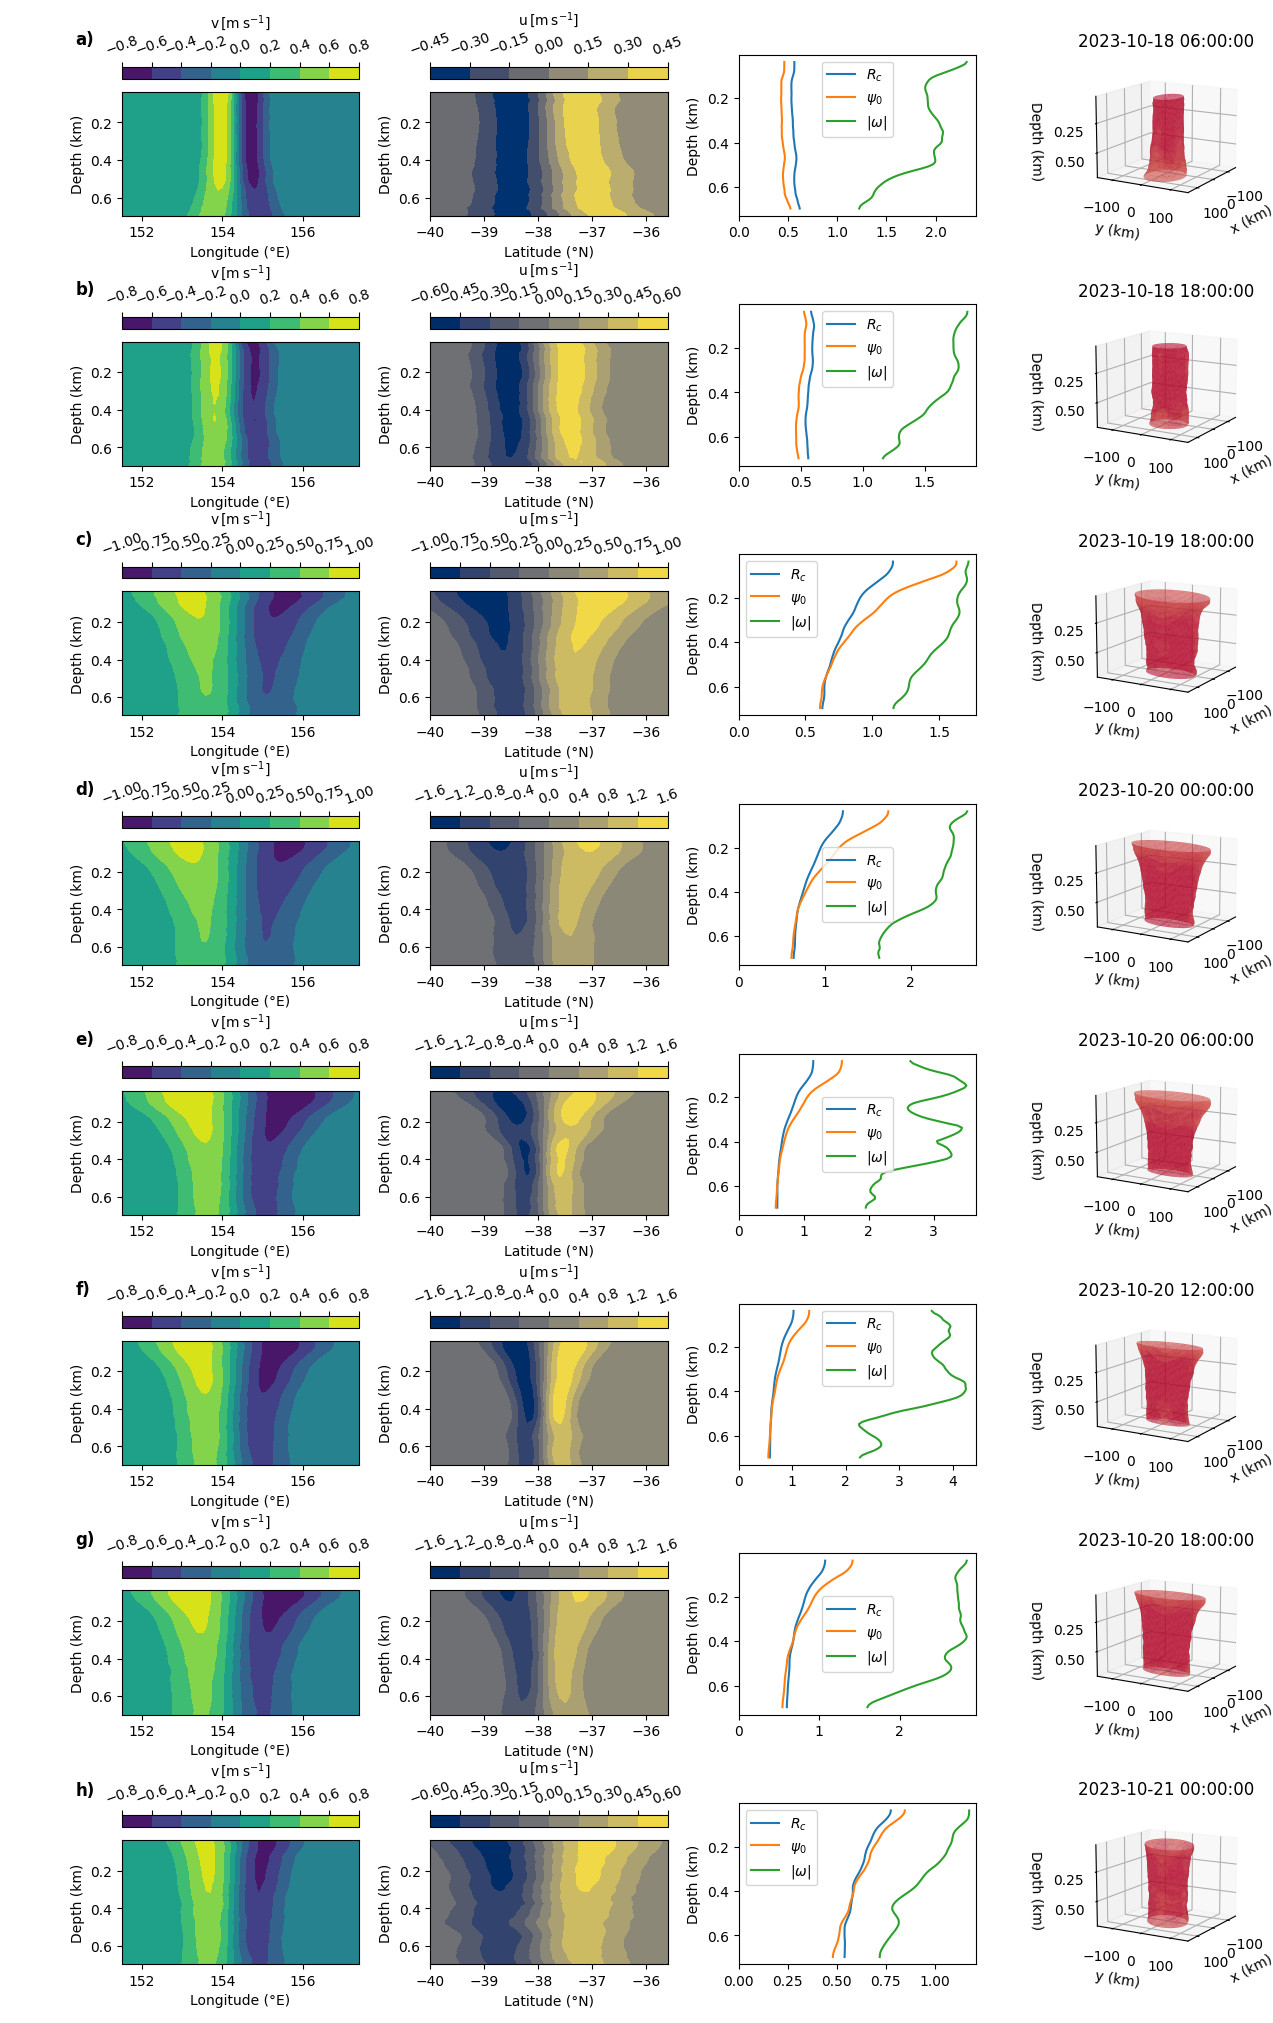

In [20]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes
from scipy.ndimage import map_coordinates
from matplotlib import cm
from matplotlib.colors import Normalize
import cmocean

times = df_data['Time'].unique()
n = len(times)
vabs = 1.0  # symmetric colour scale

fig = plt.figure(figsize=(15, 3.1 * n))
gs  = gridspec.GridSpec(n, 4,
                        width_ratios=[1, 1, 1, 1],
                        height_ratios=[1]*n,
                        hspace=0.55, wspace=0.3,
                        figure=fig)

pp = np.linspace(6.05 + .05, 6.05 - .8*7 + .085, 8)
for i, t in enumerate(times):
    # --- compute your fields for this t ---
    lon = np.arange(151.5, 157.5, .1)
    lat = np.arange(-40, -35.5, .1)
    Lon, Lat = np.meshgrid(lon, lat)
    df = df_data[df_data['Time'] == t]

    U = np.zeros((Lon.shape[0], Lon.shape[1], len(df)))
    V = np.zeros_like(U)
    for j, (_, row) in enumerate(df.iterrows()):
        u, v, _, _ = gaussian_vel_reconstruction(
            row.xc, row.yc,
            row.sQ11, row.sQ12, row.sQ22,
            row.sRc, row.spsi0,
            X=Lon, Y=Lat
        )
        U[:, :, j], V[:, :, j] = u, v

    lon0, lat0 = Lon.mean(), Lat.mean()
    X = (Lon - lon0) * 111 * np.cos(np.deg2rad(lat0))
    Y = (Lat - lat0) * 111
    dx, dy = np.diff(X[0, :])[0], np.diff(Y[:, 0])[0]

    ow = calc_ow(U, V, dx, dy, transpose=True)
    sigma_ow = normalize_matrix(ow)
    Xg, Yg, Zg = np.meshgrid(X[0, :], Y[:, 0], df['z']/1000, indexing='ij')
    Xg -= -100
    Yg -= 50

    # --- axes for this row ---
    ax0 = fig.add_subplot(gs[i, 0])
    ax1 = fig.add_subplot(gs[i, 1])
    ax2 = fig.add_subplot(gs[i, 2])
    ax3 = fig.add_subplot(gs[i, 3], projection='3d')

    # panel 1: V‐slice
    cf0 = ax0.contourf(
        lon, df['z']/1000,
        V[V.shape[0]//2, :, :].T,
        cmap='viridis', #vmin=-vabs, vmax=vabs, levels=20
    )
    ax0.invert_yaxis()
    ax0.set(xlabel='Longitude (°E)', ylabel='Depth (km)')

    # panel 2: U‐slice
    cf1 = ax1.contourf(
        lat, df['z']/1000,
        U[:, U.shape[1]//2, :].T,
        cmap='cividis', #vmin=-vabs, vmax=vabs, levels=20
    )
    ax1.invert_yaxis()
    ax1.set(xlabel='Latitude (°N)', ylabel='Depth (km)')

    

    # horizontal colourbars
    c0 = fig.colorbar(cf0, ax=ax0,
                 orientation='horizontal',
                 pad=0.08, location='top',
                 label=r'v$\,$[m s$^{-1}$]')
    c0.ax.tick_params(axis='x', labelrotation=20)
    c1 = fig.colorbar(cf1, ax=ax1,
                 orientation='horizontal',
                 pad=0.08, location='top',
                 label=r'u$\,$[m s$^{-1}$]')
    c1.ax.tick_params(axis='x', labelrotation=20)

    # panel 3: 

    ax2.plot(df['sRc'], df['z']/1000, label=r'$R_c$')
    ax2.plot(df['spsi0'], df['z']/1000, label=r'$\psi_0$')
    ax2.plot(np.abs(2 * (df['sQ11'] + df['sQ22'])), df['z']/1000, color='tab:green', label=r'$|\omega|$')
    ax2.invert_yaxis()
    ax2.set_xlim(0, None)
    ax2.legend()
    ax2.set_ylabel('Depth (km)')

    # panel 4: 3D isosurface
    verts, faces, normals, values = marching_cubes(sigma_ow, level=-.2)
    pts    = verts.T
    real_x = map_coordinates(Xg, pts, order=1)
    real_y = map_coordinates(Yg, pts, order=1)
    real_z = map_coordinates(Zg, pts, order=1)
    real_verts = np.vstack((real_x, real_y, real_z)).T

    # shade faces by mean value
    norm3 = Normalize(vmin=sigma_ow.min(), vmax=sigma_ow.max())
    face_vals = values[faces].mean(axis=1)
    face_colors = cm.coolwarm(norm3(face_vals))

    mesh = Poly3DCollection(real_verts[faces],
                            facecolors=face_colors,
                            edgecolor='none',
                            alpha=0.7)
    ax3.add_collection3d(mesh)

    # ax3.set(xlim=(Xg.min(), Xg.max()),
    #         ylim=(Yg.min(), Yg.max()),
    #         zlim=(Zg.min(), Zg.max()),
    #         xlabel='x (km)', ylabel='y (km)', zlabel='Depth (km)')
    ax3.set(xlim=(-150, 150),
            ylim=(-150, 150),
            zlim=(Zg.min(), Zg.max()),
            xlabel='x (km)', ylabel='y (km)', zlabel='Depth (km)')
    ax3.invert_zaxis()
    ax3.set_box_aspect((1, 1, .8))
    ax3.view_init(elev=13, azim=30)
    ax3.set_title(str(t))

    fig.text(-1.89, pp[i], int_to_excel(i)+')', transform=ax.transAxes, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()
